# Подготовка данных

### Подключение библиотек и скриптов

In [1]:
# Основные библиотеки 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Контроль предупреждений
import warnings
warnings.filterwarnings('ignore')

# Разделение датасета
from sklearn.model_selection import train_test_split

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Метрики качества
from sklearn.metrics import r2_score as r2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

# Cохранение модели
import pickle   

### Пути к директориям и файлам

In [2]:
train_dataset = '/Users/Katya/Downloads/Курсовой проект/train.csv'
test_dataset = '/Users/Katya/Downloads/Курсовой проект/test.csv'
result_dataset = '/Users/Katya/Downloads/Курсовой проект/result.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [3]:
# Создание датафреймов
train = pd.read_csv(train_dataset)
test = pd.read_csv(test_dataset)

In [4]:
# Уменьшение объема памяти, который занимает датасет
def reduce_memory_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [6]:
# Проверка размеров тренировочной и тестовых частей
train.shape[1]-1 == test.shape[1]

True

### Приведение типов

In [7]:
train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [8]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

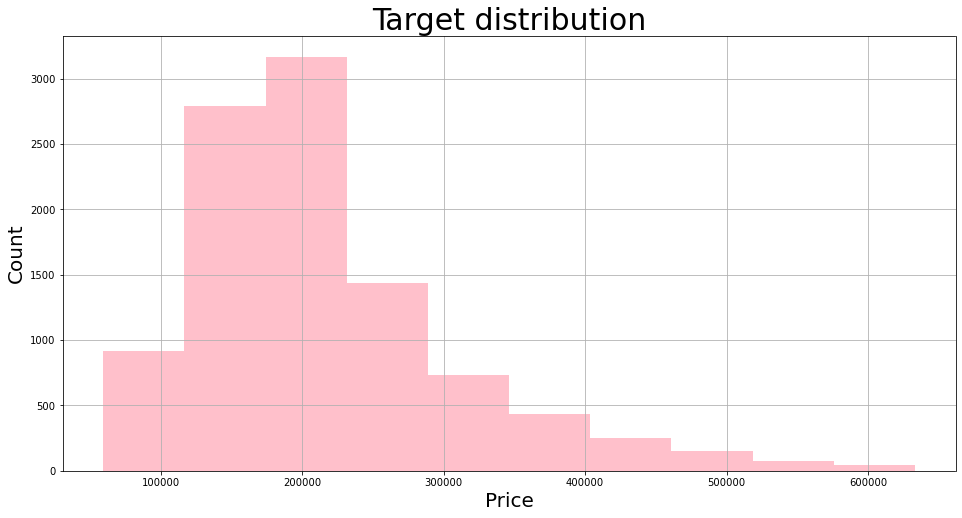

In [9]:
plt.figure(figsize = (16, 8))

train['Price'].hist(color="pink")
plt.ylabel('Count', fontsize=20)
plt.xlabel('Price', fontsize=20)

plt.title('Target distribution', fontsize=30)
plt.show()

**Количественные переменные**

In [10]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


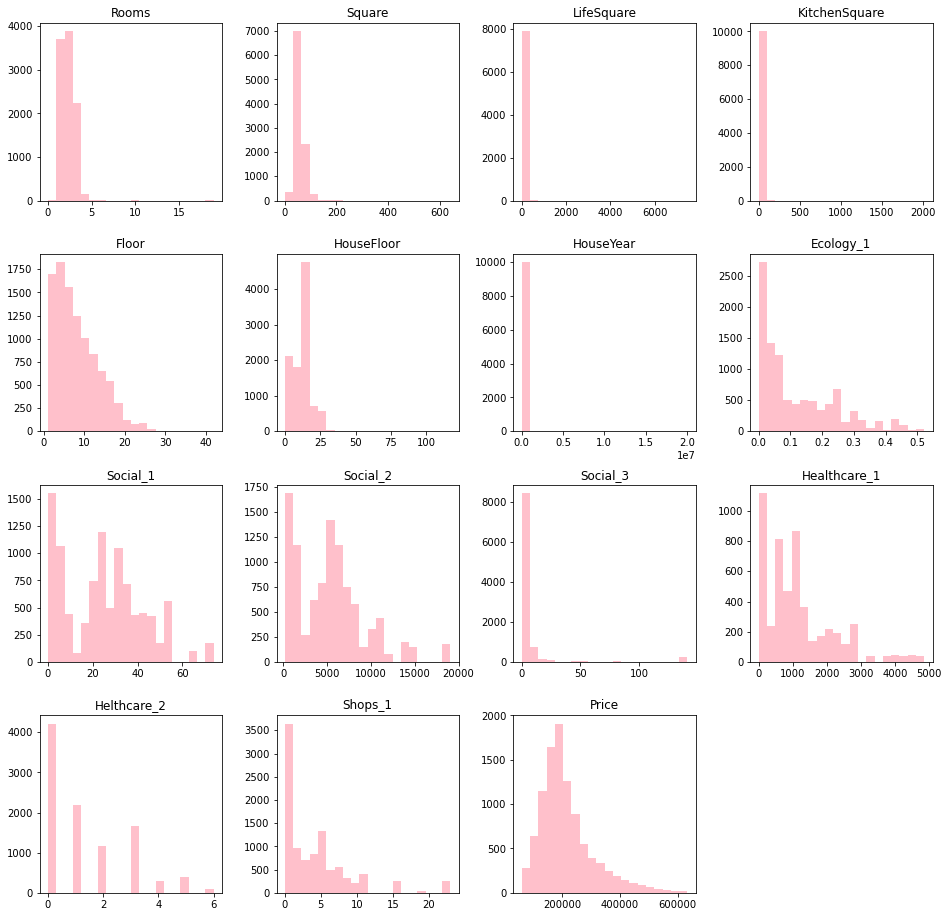

In [11]:
train_num_features = train.select_dtypes(include=['int8', 'int32', 'int16', 'float32'])
train_num_features.hist(figsize=(16,16), bins=20, grid=False, color="pink");

**Номинативные переменные**

In [12]:
train.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId']

In [13]:
train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

### Обработка пропусков

In [14]:
train.isna()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [15]:
# Проверяем количество пропусков в каждой колонке
train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [16]:
## Заменяем пропуски в колонках 'LifeSquare' и 'Healthcare_1' на медиан
medians = train[['LifeSquare', 'Healthcare_1']].median()
medians

LifeSquare       32.781261
Healthcare_1    900.000000
dtype: float32

In [17]:
train[['LifeSquare', 'Healthcare_1']] = \
        train[['LifeSquare', 'Healthcare_1']].fillna(medians)

In [18]:
train.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

### Обработка выбросов

**Rooms**

In [19]:
train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [20]:
# Заменяем количество 0 на медиан
train.loc[(train['Rooms'] == 0), 'Rooms'] = 1
train.loc[train['Rooms'] > 6, 'Rooms'] = train['Rooms'].median()
train['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

**Square, LifeSquare, KitchenSquare**

In [21]:
# Приближаем размеры квартир к более реалистичным показателям
train.loc[(train.Square<1.5), 'Square']= train['Square']*100
train.loc[(train.Square<=13), 'Square']= train['Square']*10
train.loc[(train.Square>300), 'Square']= train['Square']/10

train.loc[(train.LifeSquare<1.5), 'LifeSquare']= train['LifeSquare']*100
train.loc[(train.LifeSquare<=13), 'LifeSquare']= train['LifeSquare']*10
train.loc[(train.LifeSquare>300), 'LifeSquare']= train['LifeSquare']/10

train.loc[(train.KitchenSquare<1.5), 'KitchenSquare']= train['KitchenSquare']*100
train.loc[(train.KitchenSquare<=13), 'KitchenSquare']= train['KitchenSquare']*10
train.loc[(train.KitchenSquare>300), 'KitchenSquare']= train['KitchenSquare']/10

In [22]:
# Удваиваем общую площадь квартир на 30%, если сумма 'LifeSquare' + 'KitchenSquare' больше 'Square'
train.loc[(train.Square < (train.LifeSquare + train.KitchenSquare)), 'Square']= train['Square']*1.3

In [23]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,149.535507,32.781261,100.0,4,10.0,2014,0.075424,B,B,11,3097,0,900.0,0,0,B,305018.875000
1,3013,22,1.0,51.782280,23.169222,80.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,101.844879,47.671970,100.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,52.532879,32.781261,100.0,10,22.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,168106.000000
4,13866,94,2.0,83.570580,38.562515,90.0,16,16.0,1972,0.282798,B,B,33,8667,2,900.0,0,6,B,343995.093750


**HouseFloor, Floor**

In [24]:
train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [25]:
# Заменяем этаж "0" на медиану 
train.loc[train['HouseFloor'].isin([0]), 'HouseFloor'] = train['HouseFloor'].median()

In [26]:
train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

**HouseYear**

In [27]:
# Исправляем ошибочные даты постройки дома
train['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [28]:
train.loc[train['HouseYear'] > 2021, 'HouseYear'] = 2020

### Отбор и построение новых признаков<a class='anchor' id='feature'>


In [29]:
# "Id" для сохранения файла
test_idx = test['Id']

**Dummies**

In [30]:
binary_to_numbers = {'A': 0, 'B': 1}

train['Ecology_2'] = train['Ecology_2'].replace(binary_to_numbers)
train['Ecology_3'] = train['Ecology_3'].replace(binary_to_numbers)
train['Shops_2'] = train['Shops_2'].replace(binary_to_numbers)

**MedPriceByDistrict**

In [31]:
# Добавляем признак цена за метр квадратный
med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [32]:
train = train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
0,11809,27,3.0,149.535507,32.781261,100.0,4,10.0,2014,0.075424,...,1,11,3097,0,900.0,0,0,1,305018.875000,213530.781250
1,3013,22,1.0,51.782280,23.169222,80.0,7,8.0,1966,0.118537,...,1,30,6207,1,1183.0,1,0,1,177734.546875,146032.828125
2,8215,1,3.0,101.844879,47.671970,100.0,2,17.0,1988,0.025609,...,1,33,5261,0,240.0,3,1,1,282078.718750,244005.281250
3,2352,1,1.0,52.532879,32.781261,100.0,10,22.0,1977,0.007122,...,1,1,264,0,900.0,0,1,1,168106.000000,146735.671875
4,13866,94,2.0,83.570580,38.562515,90.0,16,16.0,1972,0.282798,...,1,33,8667,2,900.0,0,6,1,343995.093750,201584.437500


### Подготовка данных

In [33]:
class DataPipeline():
    
    def __init__(self):
        self.binary_to_numbers = None
        self.med_price_by_district = None
        
    def fit(self, X, Y=None):
        X = X.copy()
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        df = X.copy()
        
        if Y is not None:
            df['Price'] = Y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
        
    def transform(self, X):
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers) 
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        return X
        

### Отбор признаков

In [34]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'MedPriceByDistrict']

In [35]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_2', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Shops_1', 'Shops_2']

new_feature_names = ['MedPriceByDistrict']

target = 'Price'

### Подготавливаем тестовые данные


In [36]:
test['Id'] = test['Id'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)

In [37]:
medians = test[['LifeSquare', 'Healthcare_1']].median()
medians

LifeSquare       32.925087
Healthcare_1    900.000000
dtype: float32

In [38]:
test[['LifeSquare', 'Healthcare_1']] = \
        test[['LifeSquare', 'Healthcare_1']].fillna(medians)

In [39]:
test.loc[(test['Rooms'] == 0), 'Rooms'] = 1
test.loc[test['Rooms'] > 6, 'Rooms'] = test['Rooms'].median()
test['Rooms'].value_counts()

2.0    2031
1.0    1771
3.0    1099
4.0      90
5.0       7
6.0       2
Name: Rooms, dtype: int64

In [40]:
test.loc[(test.Square<1.5), 'Square']= test['Square']*100
test.loc[(test.Square<=13), 'Square']= test['Square']*10
test.loc[(test.Square>300), 'Square']= test['Square']/10

test.loc[(test.LifeSquare<1.5), 'LifeSquare']= test['LifeSquare']*100
test.loc[(test.LifeSquare<=13), 'LifeSquare']= test['LifeSquare']*10
test.loc[(test.LifeSquare>300), 'LifeSquare']= test['LifeSquare']/10

test.loc[(test.KitchenSquare<1.5), 'KitchenSquare']= test['KitchenSquare']*100
test.loc[(test.KitchenSquare<=13), 'KitchenSquare']= test['KitchenSquare']*10
test.loc[(test.KitchenSquare>300), 'KitchenSquare']= test['KitchenSquare']/10

In [41]:
test.loc[(test.Square < (test.LifeSquare + test.KitchenSquare)), 'Square']= test['Square']*1.3

In [42]:
test.loc[test['HouseYear'] > 2021, 'HouseYear'] = 2020

In [43]:
test.loc[test['HouseFloor'].isin([0]), 'HouseFloor'] = test['HouseFloor'].median()

In [44]:
binary_to_numbers = {'A': 0, 'B': 1}

test['Ecology_2'] = test['Ecology_2'].replace(binary_to_numbers)
test['Ecology_3'] = test['Ecology_3'].replace(binary_to_numbers)
test['Shops_2'] = test['Shops_2'].replace(binary_to_numbers)

In [45]:
test = test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict
0,4567,44,1.0,47.901917,19.094183,50.0,5,9.0,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1,171145.171875
1,5925,62,1.0,55.242077,42.568134,100.0,7,17.0,2017,0.072158,1,1,2,629,1,900.0,0,0,0,129107.218750
2,960,27,2.0,77.302780,32.925087,90.0,19,19.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1,165683.078125
3,3848,23,3.0,64.539841,33.893826,60.0,2,2.0,1965,0.014073,1,1,2,475,0,900.0,0,0,1,166687.734375
4,746,74,1.0,69.988167,32.925087,100.0,8,17.0,1977,0.309479,1,1,35,7715,4,990.0,0,6,1,165071.828125


### Разбиение на train и test

In [46]:
X = train.drop(columns=target)
Y = train[target]

In [47]:
X_train, X_valid, Y_train, Y_valid= train_test_split(X, Y, test_size=5000, random_state=42)

In [48]:
DataPipeline = DataPipeline()
DataPipeline.fit(X_train, Y_train)

X_train = DataPipeline.transform(X_train)
X_valid = DataPipeline.transform(X_valid)
test = DataPipeline.transform(test)

In [49]:
X_train = X_train[feature_names]
X_valid = X_valid[feature_names]
test = test[feature_names]

**Обучение модели**

In [50]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, 
                                 min_samples_leaf=3, 
                                 random_state=42,
                                 n_estimators=100  
                                 )

rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=3, random_state=42)

In [51]:
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

**Оценка модели**

In [52]:
r2(Y_train, y_train_preds)

0.9012236215725531

# Прогнозирование на тестовом датасете

In [53]:
X_test = test

In [54]:
y_test_preds = rf_model.predict(X_test)

In [55]:
y_test_preds

array([161888.30925728, 118473.33833459, 142923.24082349, ...,
       147438.4338656 , 195602.11628113, 266907.8822743 ])

 # Сохранение модели

In [56]:
result=pd.DataFrame({'Id':test_idx, 'Price':y_test_preds})


In [57]:
result.to_csv(result_dataset, index=False)